In [ ]:
from __future__ import print_function
import torch
from utils import Plotting,accuracy_plotting
#from model import model_1,model_2,model_3,model_4,model_summary
from model import model_1,model_summary
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28))
                                       #transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       #transforms.RandomRotation((-15., 15.), fill=1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #rightness=0.10, contrast=0.1,transforms.ColorJitter(b saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 180581025.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97926995.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67490547.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21333178.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


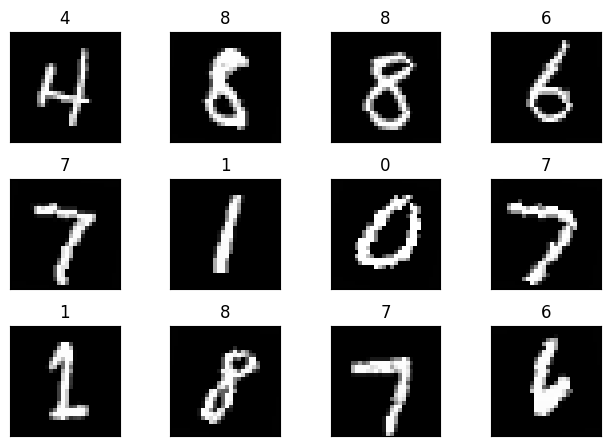

In [ ]:
Plotting(train_loader)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model1 = model_1().to(device)
model_summary(model1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              54
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 12, 28, 28]             648
              ReLU-4           [-1, 12, 28, 28]               0
         MaxPool2d-5           [-1, 12, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             120
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8            [-1, 8, 12, 12]             720
              ReLU-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]              80
             ReLU-11           [-1, 10, 12, 12]               0
AdaptiveAvgPool2d-12             [-1, 10, 1, 1]               0
Total params: 1,622
Trainable params: 1,622
Non-trainable params: 0
-----------------------------------

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.301335096359253 Batch_id=468 Accuracy=13.76: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 2.3012, Accuracy: 1580/10000 (15.80%)

EPOCH: 1


Loss=2.093993902206421 Batch_id=468 Accuracy=13.03: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]



Test set: Average loss: 2.1556, Accuracy: 2025/10000 (20.25%)

EPOCH: 2


Loss=1.4088941812515259 Batch_id=468 Accuracy=32.55: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]



Test set: Average loss: 1.3368, Accuracy: 4981/10000 (49.81%)

EPOCH: 3


Loss=1.3407961130142212 Batch_id=468 Accuracy=58.31: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]



Test set: Average loss: 0.9048, Accuracy: 7086/10000 (70.86%)

EPOCH: 4


Loss=0.8879316449165344 Batch_id=468 Accuracy=67.21: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.9016, Accuracy: 6683/10000 (66.83%)

EPOCH: 5


Loss=0.6392890810966492 Batch_id=468 Accuracy=73.78: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.5586, Accuracy: 8233/10000 (82.33%)

EPOCH: 6


Loss=0.6667251586914062 Batch_id=468 Accuracy=77.69: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]



Test set: Average loss: 0.4986, Accuracy: 8367/10000 (83.67%)

EPOCH: 7


Loss=0.5436765551567078 Batch_id=468 Accuracy=80.88: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.5811, Accuracy: 8158/10000 (81.58%)

EPOCH: 8


Loss=0.42193686962127686 Batch_id=468 Accuracy=83.47: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]



Test set: Average loss: 0.4223, Accuracy: 8679/10000 (86.79%)

EPOCH: 9


Loss=0.3711714744567871 Batch_id=468 Accuracy=84.90: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]



Test set: Average loss: 0.3408, Accuracy: 8924/10000 (89.24%)

EPOCH: 10


Loss=0.3643142282962799 Batch_id=468 Accuracy=86.54: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.2826, Accuracy: 9126/10000 (91.26%)

EPOCH: 11


Loss=0.4096814692020416 Batch_id=468 Accuracy=87.19: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]



Test set: Average loss: 0.3119, Accuracy: 9057/10000 (90.57%)

EPOCH: 12


Loss=0.3204965591430664 Batch_id=468 Accuracy=88.20: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]



Test set: Average loss: 0.2831, Accuracy: 9122/10000 (91.22%)

EPOCH: 13


Loss=0.27041712403297424 Batch_id=468 Accuracy=89.19: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]



Test set: Average loss: 0.2398, Accuracy: 9229/10000 (92.29%)

EPOCH: 14


Loss=0.4262210428714752 Batch_id=468 Accuracy=89.52: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.2483, Accuracy: 9217/10000 (92.17%)



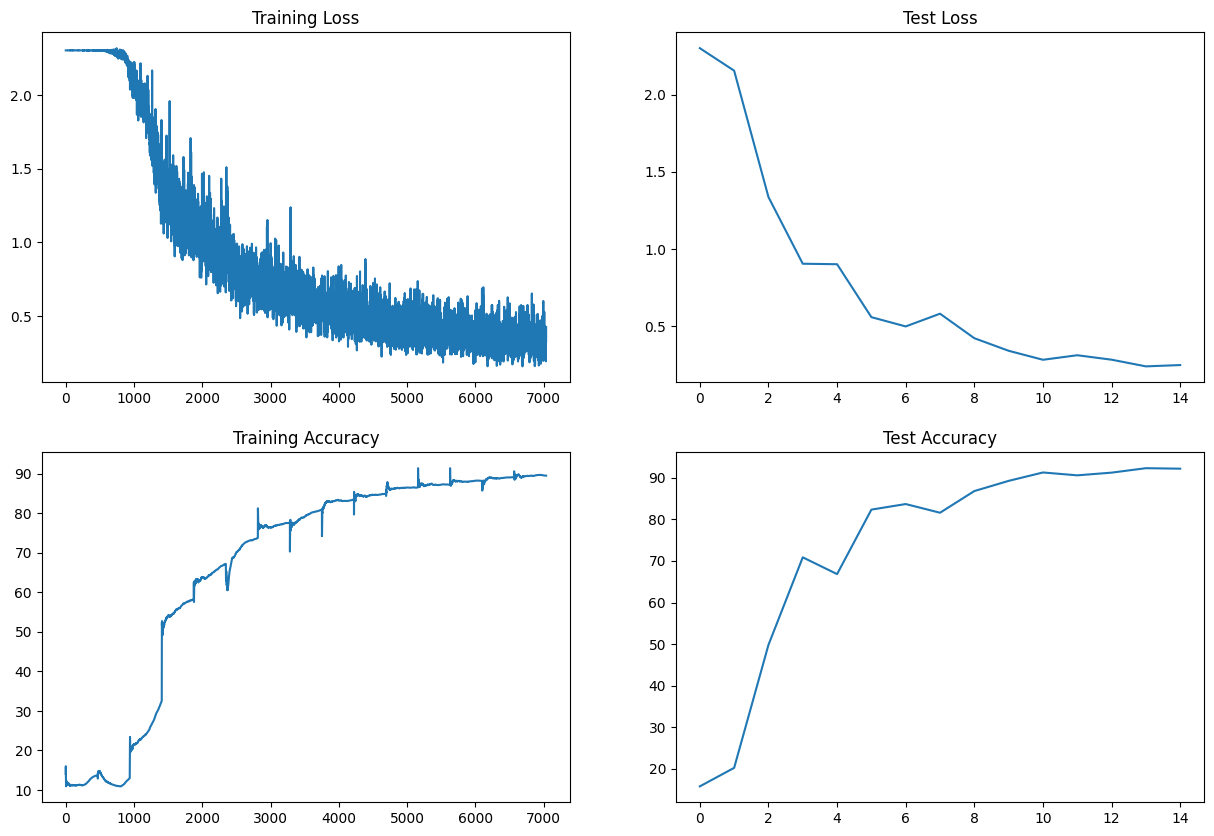

In [ ]:
accuracy_plotting(train_losses,train_acc,test_losses,test_acc)

## Longer runtimes

All Colab runtimes are reset after some period of time &#40;which is faster if the runtime isn't executing code&#41;. Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.


## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.

If you encounter limitations, you can relax those limitations by purchasing more compute units via pay as you go. Anyone can purchase compute units via <a href="https://colab.research.google.com/signup">pay as you go</a>; no subscription is required.

## Send us feedback!

<p>If you have any feedback for us, please let us know. The best way to send feedback is by using the Help &gt; 'Send feedback…' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.</p>
<p>If you encounter errors or other issues with billing &#40;payments&#41; for Colab Pro, Pro+ or pay as you go, please email <a href="mailto:colab-billing@google.com">colab-billing@google.com</a>.</p>

## More resources

### Working with notebooks in Colab
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with data
- [Loading data: Drive, Sheets and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualising data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine learning crash course
These are a few of the notebooks from Google's online machine learning course. See the <a href="https://developers.google.com/machine-learning/crash-course/">full course website</a> for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using accelerated hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine learning examples

To see end-to-end examples of the interactive machine-learning analyses that Colaboratory makes possible, take a look at these tutorials using models from <a href="https://tfhub.dev">TensorFlow Hub</a>.

A few featured examples:

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Retraining an Image Classifier</a>: Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Text Classification</a>: Classify IMDB film reviews as either <em>positive</em> or <em>negative</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Style Transfer</a>: Use deep learning to transfer style between images.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: Use a machine-learning model to answer questions from the SQuAD dataset.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Video Interpolation</a>: Predict what happened in a video between the first and the last frame.
